<a href="https://colab.research.google.com/github/praptiii/Data-Analyst-Internship-Project/blob/main/DA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_path = "/content/drive/MyDrive/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("ecom_data")

import os
print(os.listdir("ecom_data"))

['thelook_ecommerce.order_items.csv', 'thelook_ecommerce.distribution_centers.csv', 'thelook_ecommerce.orders.csv', 'thelook_ecommerce.products.csv', 'thelook_ecommerce.inventory_items.csv', 'thelook_ecommerce.events.csv', 'thelook_ecommerce.users.csv']


In [4]:
# Load datasets
orders = pd.read_csv("ecom_data/thelook_ecommerce.orders.csv")
order_items = pd.read_csv("ecom_data/thelook_ecommerce.order_items.csv")
products = pd.read_csv("ecom_data/thelook_ecommerce.products.csv")
users = pd.read_csv("ecom_data/thelook_ecommerce.users.csv")
events = pd.read_csv("ecom_data/thelook_ecommerce.events.csv")

In [5]:
# Create Return Flag
order_items['return_flag'] = order_items['returned_at'].notnull().astype(int)

In [6]:
# Merge Datasets
df = order_items.merge(products, left_on='product_id', right_on='id', how='left', suffixes=('', '_product'))

In [7]:
df = df.merge(orders[['order_id', 'user_id', 'status']], left_on='order_id', right_on='order_id', how='left', suffixes=('', '_order'))

In [8]:
df = df.merge(users, left_on='user_id', right_on='id', how='left', suffixes=('', '_user'))

In [9]:
events_latest = events.sort_values('created_at').drop_duplicates('user_id', keep='last')
df = df.merge(events_latest[['user_id', 'traffic_source']], on='user_id', how='left')

In [10]:
df.columns.tolist()

['id',
 'order_id',
 'user_id',
 'product_id',
 'inventory_item_id',
 'status',
 'created_at',
 'shipped_at',
 'delivered_at',
 'returned_at',
 'sale_price',
 'return_flag',
 'id_product',
 'cost',
 'category',
 'name',
 'brand',
 'retail_price',
 'department',
 'sku',
 'distribution_center_id',
 'user_id_order',
 'status_order',
 'id_user',
 'first_name',
 'last_name',
 'email',
 'age',
 'gender',
 'state',
 'street_address',
 'postal_code',
 'city',
 'country',
 'latitude',
 'longitude',
 'traffic_source_x',
 'created_at_user',
 'traffic_source_y']

In [11]:
# Clean up and rename
df = df.drop(columns=[
    'id_product',            # from products
    'id_user',               # from users
    'user_id_order',         # from orders
    'status_order',          # duplicate of 'status'
    'returned_at',           # already encoded as return_flag
    'shipped_at',
    'delivered_at',
    'created_at_user',       # user creation timestamp
], errors='ignore')

df = df.rename(columns={'traffic_source_y': 'traffic_source'})

df.columns

Index(['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'sale_price', 'return_flag', 'cost', 'category',
       'name', 'brand', 'retail_price', 'department', 'sku',
       'distribution_center_id', 'first_name', 'last_name', 'email', 'age',
       'gender', 'state', 'street_address', 'postal_code', 'city', 'country',
       'latitude', 'longitude', 'traffic_source_x', 'traffic_source'],
      dtype='object')

In [12]:
print("\nMissing values per column before cleaning:\n")
print(df.isnull().sum())


Missing values per column before cleaning:

id                           0
order_id                     0
user_id                      0
product_id                   0
inventory_item_id            0
status                       0
created_at                   0
sale_price                   0
return_flag                  0
cost                         0
category                     0
name                        11
brand                      146
retail_price                 0
department                   0
sku                          0
distribution_center_id       0
first_name                   0
last_name                    0
email                        0
age                          0
gender                       0
state                        0
street_address               0
postal_code                  0
city                      1779
country                      0
latitude                     0
longitude                    0
traffic_source_x             0
traffic_source           

In [13]:
# Fill missing values
df['name'] = df['name'].fillna('Unknown')
df['brand'] = df['brand'].fillna('Unknown')
df['city'] = df['city'].fillna('Unknown')
df['traffic_source'] = df['traffic_source'].fillna('unknown')

In [14]:
print("\nMissing values per column after cleaning:\n")
print(df.isnull().sum())


Missing values per column after cleaning:

id                        0
order_id                  0
user_id                   0
product_id                0
inventory_item_id         0
status                    0
created_at                0
sale_price                0
return_flag               0
cost                      0
category                  0
name                      0
brand                     0
retail_price              0
department                0
sku                       0
distribution_center_id    0
first_name                0
last_name                 0
email                     0
age                       0
gender                    0
state                     0
street_address            0
postal_code               0
city                      0
country                   0
latitude                  0
longitude                 0
traffic_source_x          0
traffic_source            0
dtype: int64


In [15]:
# Feature Engineering
df['price_margin'] = df['sale_price'] - df['cost']
df['discount'] = df['retail_price'] - df['sale_price']
df['is_discounted'] = (df['sale_price'] < df['retail_price']).astype(int)
df['order_day'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce').dt.dayofweek

In [16]:
# Summary return rates
# By Category
return_rate_by_category = df.groupby('category')['return_flag'].agg(['count', 'sum'])
return_rate_by_category['return_rate'] = (return_rate_by_category['sum'] / return_rate_by_category['count']) * 100
return_rate_by_category = return_rate_by_category.sort_values(by='return_rate', ascending=False)

print("\n Return Rate by Product Category:")
print(return_rate_by_category.head(10))  # top 10


 Return Rate by Product Category:
                   count   sum  return_rate
category                                   
Clothing Sets        185    22    11.891892
Plus                4204   457    10.870599
Shorts             11002  1183    10.752590
Underwear           7634   810    10.610427
Pants               7235   752    10.393918
Leggings            3164   327    10.335019
Outerwear & Coats   9040   929    10.276549
Skirts              2055   209    10.170316
Intimates          13253  1345    10.148646
Socks               6306   639    10.133206


In [17]:
# By Brand
return_rate_by_brand = df.groupby('brand')['return_flag'].agg(['count', 'sum'])
return_rate_by_brand['return_rate'] = (return_rate_by_brand['sum'] / return_rate_by_brand['count']) * 100
return_rate_by_brand = return_rate_by_brand.sort_values(by='return_rate', ascending=False)

print("\n Return Rate by Brand (Supplier):")
print(return_rate_by_brand.head(10))  # top 10 brands


 Return Rate by Brand (Supplier):
                    count  sum  return_rate
brand                                      
Islandia                4    3    75.000000
Fashion Apparel         3    2    66.666667
DeepPocket              3    2    66.666667
Candies                 3    2    66.666667
Christopher Kelenc      6    4    66.666667
Fashion                 3    2    66.666667
ITC                     5    3    60.000000
Projeck Raw             5    3    60.000000
Lily White              5    3    60.000000
Snob                    2    1    50.000000


In [18]:
# By department
return_rate_by_dept = df.groupby('department')['return_flag'].agg(['count', 'sum'])
return_rate_by_dept['return_rate'] = (return_rate_by_dept['sum'] / return_rate_by_dept['count']) * 100
print("\n Return Rate by Department:")
print(return_rate_by_dept.sort_values(by='return_rate', ascending=False))

# By distribution center
return_rate_by_dc = df.groupby('distribution_center_id')['return_flag'].agg(['count', 'sum'])
return_rate_by_dc['return_rate'] = (return_rate_by_dc['sum'] / return_rate_by_dc['count']) * 100
print("\n Return Rate by Distribution Center:")
print(return_rate_by_dc.sort_values(by='return_rate', ascending=False))



 Return Rate by Department:
            count   sum  return_rate
department                          
Men         90757  9172    10.106108
Women       90195  9015     9.995011

 Return Rate by Distribution Center:
                        count   sum  return_rate
distribution_center_id                          
3                       22585  2331    10.321010
10                      11791  1215    10.304470
9                       16825  1711    10.169391
6                       16308  1647    10.099338
4                       17383  1750    10.067307
1                       24212  2434    10.052866
7                       16918  1694    10.013004
8                       18129  1797     9.912295
2                       23919  2350     9.824825
5                       12882  1258     9.765564


In [19]:
!pip install -U imbalanced-learn

In [20]:
# Selected features and target
features = ['category', 'brand', 'department', 'gender', 'state', 'traffic_source',
            'sale_price', 'cost', 'retail_price', 'age',
            'price_margin', 'discount', 'is_discounted', 'order_day']
target = 'return_flag'

X = df[features]
y = df[target]

In [21]:
# Split categorical and numerical columns
categorical_features = ['category', 'brand', 'department', 'gender', 'state', 'traffic_source']
numerical_features = ['sale_price', 'cost', 'retail_price', 'age',
                      'price_margin', 'discount', 'is_discounted', 'order_day']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handles NaNs
            ('scaler', StandardScaler())
        ]), numerical_features)
    ]
)

In [22]:
# Logistic regression pipeline with SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=500))
])

# Train-test split and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'brand',
                                                   'department', 'gender',
                                                   'state', 'traffic_source']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sale_price', 'cost',
                                                   'retail_price', 'age',
                                                   'price_margin', 'discount',
                                                   'is_discounted',
                                                   'order_day'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [23]:
# Predictions
y_pred = pipeline.predict(X_test)

# Model evaluation
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.52      0.66     32489
           1       0.10      0.49      0.17      3702

    accuracy                           0.52     36191
   macro avg       0.50      0.51      0.42     36191
weighted avg       0.82      0.52      0.61     36191


 Confusion Matrix:
[[16981 15508]
 [ 1892  1810]]


In [24]:
# Feature importance
model = pipeline.named_steps['classifier']
encoder = pipeline.named_steps['preprocessing'].named_transformers_['cat']
cat_feature_names = encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([cat_feature_names, numerical_features])

coefs = model.coef_[0]
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print("\n Top Drivers of Returns (Logistic Regression Coefficients):")
print(coef_df.head(10))


 Top Drivers of Returns (Logistic Regression Coefficients):
                       Feature  Coefficient
548   brand_Christopher Kelenc     3.926337
1232            brand_Islandia     3.649732
1436            brand_La Leela     3.154112
1063             brand_Gravity     3.147326
1490          brand_Lily White     3.077796
1188                 brand_ITC     2.927484
1691       brand_Mountain Mama     2.896553
2025              brand_Rewash     2.664074
1653             brand_Missoni     2.603654
2492       brand_Trash Nouveau     2.498898


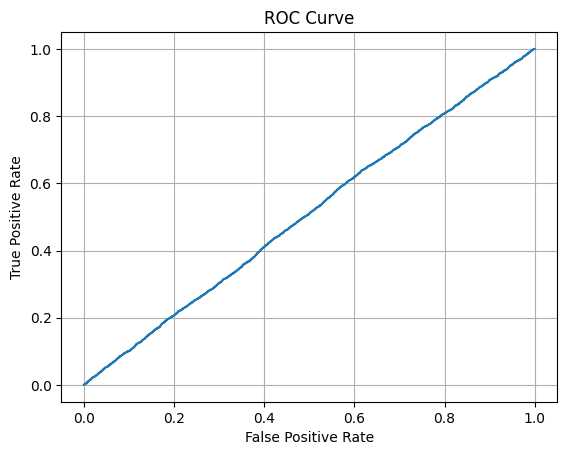

In [25]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

In [26]:
from google.colab import files

In [27]:
# Predict return probabilities
return_probs = pipeline.predict_proba(X)[:, 1]  # Probability of return (class 1)
df['return_probability'] = return_probs
high_risk_threshold = df['return_probability'].quantile(0.95)
high_risk_products = df[df['return_probability'] >= high_risk_threshold]
high_risk_products.to_csv("high_risk_products.csv", index=False)

print(f"\n Saved {len(high_risk_products)} high-risk products to high_risk_products.csv")
files.download('high_risk_products.csv')



 Saved 9048 high-risk products to high_risk_products.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# Create return summary
df_return_summary = df.groupby(['category', 'brand', 'department', 'gender', 'state', 'country', 'traffic_source']).agg(
    total_orders=('return_flag', 'count'),
    total_returns=('return_flag', 'sum')
).reset_index()
df_return_summary['return_rate'] = (df_return_summary['total_returns'] / df_return_summary['total_orders']) * 100
df_return_summary.to_csv("return_summary.csv", index=False)
files.download('return_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Clean datetime and export final dataset
df.to_csv("full_ecommerce_data.csv", index=False)
files.download("full_ecommerce_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Cleaned dataset
df = pd.read_csv("full_ecommerce_data.csv")
df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
df.to_csv("full_ecommerce_data_cleaned.csv", index=False)
files.download('full_ecommerce_data_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>